## Project Description

This project will be focusing on a machine learning area that frequently uses both supervised and unsupervised models, that being natural language processing. 

We will be exploring and creating two models for a medical dataset containing research papers on 3 different types of cancer: Thyroid, Lung and Colon.

In many cases text classification of medical documents primarily consists of unstructured free text that clinicians need to group together and harmonize in a timely manner. NLP helps to automate this process by making sense of these massive amounts of textual data.

For this project we will be employing an unsupervised learning model called Latent Dirichlet Allocation (LDA) and a deep learning algorithm known as a bidirectional LSTM. The goal is to correctly assess whether the publication is dicussing colon cancer, lung cancer, or thyroid cancer. After deploying both of these models we will compare each and discuss the pros and cons of each.

### Data Source and Description

We will be using a dataset from Kaggle. The title of the dataset is "Medical Text Dataset -Cancer Doc Classification." There are a total of 7569 publications in the dataset with two useful columns. Those being the class label column where we have our three target cancers listed and the text column, where we have our publications' text. A link to the dataset is listed below.

https://www.kaggle.com/datasets/falgunipatel19/biomedical-text-publication-classification

#### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

In [3]:
import keras
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import (LSTM, 
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D)
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from string import digits

In [4]:
from keras_preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

#### Import Data

In [5]:
df = pd.read_csv("alldata_1_for_kaggle.csv", encoding = 'latin1')

### Exploratory Data Analysis

In [6]:
df.head()

,Unnamed: 0,0,a
0,0,Thyroid_Cancer,Thyroid surgery in children in a single insti...
1,1,Thyroid_Cancer,""" The adopted strategy was the same as that us..."
2,2,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...
3,3,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...
4,4,Thyroid_Cancer,This study aimed to investigate serum matrix ...


In [7]:
df.describe()

,Unnamed: 0
count,7570.000000
mean,3784.500000
std,2185.415102
min,0.000000
25%,1892.250000
50%,3784.500000
75%,5676.750000
max,7569.000000


In [8]:
df.dtypes

Unnamed: 0     int64
0             object
a             object
dtype: object

It looks like we will not need the unnamed column as it is just an index column.

In [9]:
df=df.drop('Unnamed: 0',axis=1)

Now we can change our column names to something more intuitive.

In [10]:
df = df.rename(columns={'0': 'Target','a':'Text'})

In [11]:
df

,Target,Text
0,Thyroid_Cancer,Thyroid surgery in children in a single insti...
1,Thyroid_Cancer,""" The adopted strategy was the same as that us..."
2,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...
3,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...
4,Thyroid_Cancer,This study aimed to investigate serum matrix ...
...,...,...
7565,Colon_Cancer,we report the case of a 24yearold man who pres...
7566,Colon_Cancer,among synchronous colorectal cancers scrcs rep...
7567,Colon_Cancer,the heterogeneity of cancer cells is generally...
7568,Colon_Cancer,"""adipogenesis is the process through which mes..."


Let's look at an example of each of the 3 types of publications we will be classifying, to get an idea of what we are dealing with.

In [12]:
target_texts = df[df['Target']=='Thyroid_Cancer']['Text']
target_texts.values[1]

'" The adopted strategy was the same as that used in prior years [] and is based on four exclusive queries that return  four  disjoint  citation  subsets The first query QPub_plain is based on a plaintext search in PubMed titles and s using keywords The  second  query  QPub_indexed relies on the PubMed indexing scheme using MeSH terms and results are made exclusive of the previous set The third one QWoS_restricted is based on a plaintext search in WoS restricted to the two research areas \x9cMedical Informatics\x9d and \x9cHealth Care Sciences  Services\x9d The fourth query QWoS_filtered is based on the same plaintext search used in WoS but filtered by nonrelevant research areas eg Archeology Dance Zoology etc and the two research areas of the previous query It is of note that the two WoS queries select  only  nonPubMedindexed  papers that are supposed to be caught by the two PubMed queriesA  first  review  of  the  four  subsets  of retrieved  citations  was  performed  by  the two se

In [13]:
target_texts = df[df['Target']=='Lung_Cancer']['Text']
target_texts.values[1]

'"inhibitors by causing immediate and nearly complete intracellular and extracellular thiamine deprivation [6]. In previous studies we have shown that thiaminase has both in vitro and in vivo cytotoxicity activity further supporting the concept that TDEs could represent new targets for novel therapies [6] [7] [8]. We have also previously reported that rapamycin has antagonistic effect on thiaminase-mediated growth inhibition of leukemia cells [7] a surprising finding since rapamycin generally acts as a sensitizing agent in combination with cytotoxic drugs. We now present metabolic and metabolomic observations regarding the anticancer activities and metabolic effects of thiaminase in leukemia and breast cancer cells. We chose to focus on breast and leukemia models because these were the models in which we observed the most promising activity of thiaminase in xenografts. These studies help define thiaminase metabolic effects that may be responsible for its cytotoxic activity. These studi

In [14]:
target_texts = df[df['Target']=='Colon_Cancer']['Text']
target_texts.values[1]

'advances  in  technology  hardware  and computing have created new opportunities to improve the quality of cancer care and research  by  leveraging  informatics  innovations  digital  health  machine  learning and precision oncology are key areas where there are noteworthy advances in the field of  cancer  informatics as  the  adoption  of smartphones  and  wearable  technologies increases patientgenerated health data such as physical activity and electronic patientreported outcomes pros are being leveraged for  prevention  and  in  interventions  for remote  monitoring  during  treatment  and survivorship and to predict health outcomes moving beyond cancer clinical trials health systems are increasingly seeking to integrate pros into routine cancer care processes as part of the national cancer institute\x99s nci cancer moonshot initiative six healthcare systems will systematically integrate pros into clinical workflows and electronic health records  ehrs    additionally  much attenti

Coming from a non-medical background it is quite difficult to be able to tell a difference between these three articles. This is why in many cases it is useful to delve into datasets like these with an experienced clinician as well, so that we can be assured everything is correctly labeled.

In [15]:
df['Target'].value_counts()

Thyroid_Cancer    2810
Colon_Cancer      2580
Lung_Cancer       2180
Name: Target, dtype: int64

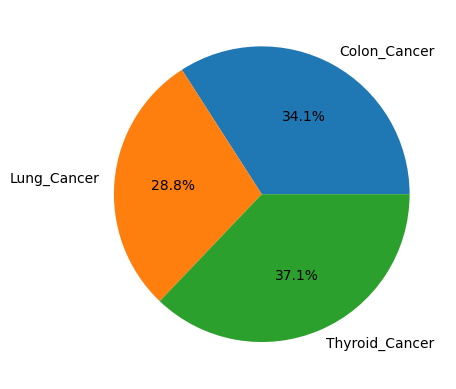

In [16]:
plt.pie(df.groupby('Target')['Target'].count(),autopct="%.1f%%",labels=['Colon_Cancer', 'Lung_Cancer', 'Thyroid_Cancer'])
plt.show()

We can see above that our three target variables are balanced for the most part, with lung cancer comprising about 8% less of the publications than thyroid cancer.

Next we can look at two very important statistics when dealing with NLP problems. Those being average word length for each target class and average word count per publication for each class.

Text(0.5, 0.98, 'Average word length for each type of cancer article')

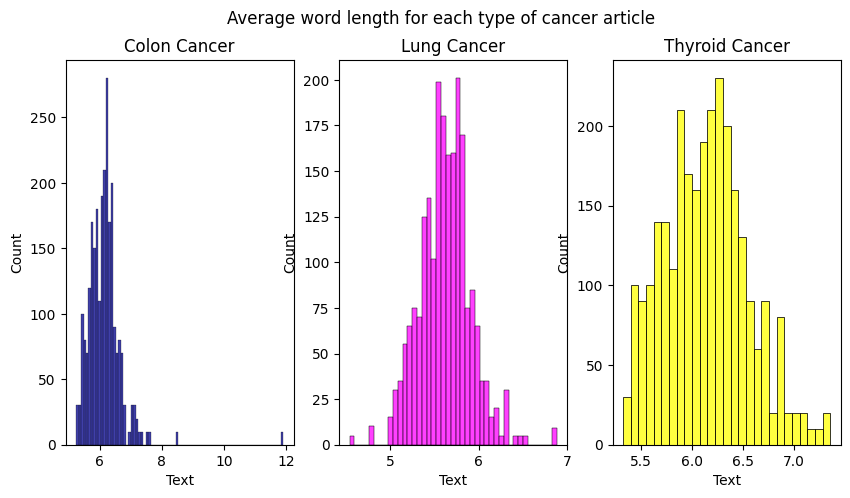

In [17]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(10,5))
word = df[df['Target']=='Colon_Cancer']['Text'].str.split().apply(lambda x : [len(i) for i in x])
sns.histplot(word.map(lambda x: np.mean(x)),ax=ax1,color='darkblue')
ax1.set_title('Colon Cancer')
word = df[df['Target']=='Lung_Cancer']['Text'].str.split().apply(lambda x : [len(i) for i in x])
sns.histplot(word.map(lambda x: np.mean(x)),ax=ax2,color='magenta')
ax2.set_title('Lung Cancer')
word = df[df['Target']=='Thyroid_Cancer']['Text'].str.split().apply(lambda x : [len(i) for i in x])
sns.histplot(word.map(lambda x: np.mean(x)),ax=ax3,color='yellow')
ax3.set_title('Thyroid Cancer')
fig.suptitle('Average word length for each type of cancer article')

Based on these plots it is apparent that our average word length is roughly the same for all three types of cancers centered between 5.5 to 6.5 characters. All three plots are roughly symmtric and normally distributed as well. Something to note is there are a few word count outliers for colon cancer. We will leave these outliers in the dataset as they could be useful for model development.

Text(0.5, 0.98, 'Words in an article')

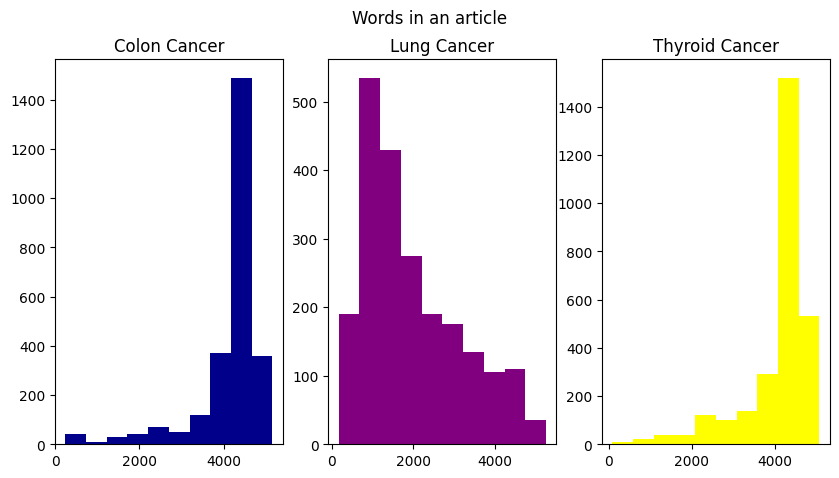

In [18]:
#Number of words in an article
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,5))
tweet_len = df[df['Target']=='Colon_Cancer']['Text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len, color='darkblue')
ax1.set_title('Colon Cancer')
tweet_len = df[df['Target']=='Lung_Cancer']['Text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='purple')
ax2.set_title('Lung Cancer')
tweet_len = df[df['Target']=='Thyroid_Cancer']['Text'].str.split().map(lambda x: len(x))
ax3.hist(tweet_len,color='yellow')
ax3.set_title('Thyroid Cancer')
fig.suptitle('Words in an article')

Our words per article for colon cancer and thyroid cancer are distributed roughly the same with a left skewed tail. Both seem to have a majority of words around 4000 per article. For lung cancer we can see that the words per article is far less, with the majority of articles containing only ~1500 words.

Now that we have visualized a few of the pertinent characteristics of the article types, it is time to clean and preprocess the data so we can properly model it.

### Data Cleaning and Preprocessing

We will first employ two standard text cleaning functions using regular expression syntax and then tokenize the text. After this we will take a look at our dataset to see if we need to do any further cleaning.

In [19]:
import re
import nltk.corpus

In [20]:
def clean_text(dataframe, text_col):
    '''
    A helper function which takes a dataframe 
    and removes punction and stopwords.
    '''
    #remove all punctuation
    dataframe['no_punct'] = dataframe[text_col].apply(lambda row: re.sub(r'[^\w\s]+', '', row))
    
    #remove numbers 
    dataframe['no_punct_num'] = dataframe['no_punct'].apply(lambda row: re.sub(r'[0-9]+', '', row))
    
    #remove stopwords
    stop_words = stopwords.words('english')
    dataframe['no_stopwords'] = dataframe['no_punct_num'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
    
    #remove extra spaces
    dataframe['clean_text'] = dataframe['no_stopwords'].apply(lambda x: re.sub(' +', ' ', x))
    return 

In [21]:
# tokenize text function
def tokenize(d):
    return word_tokenize(d)

In [22]:
#clean dataframe text column
clean_text(df, 'Text')

In [23]:
df.head()

,Target,Text,no_punct,no_punct_num,no_stopwords,clean_text
0,Thyroid_Cancer,Thyroid surgery in children in a single insti...,Thyroid surgery in children in a single insti...,Thyroid surgery in children in a single insti...,Thyroid surgery children single institution Os...,Thyroid surgery children single institution Os...
1,Thyroid_Cancer,""" The adopted strategy was the same as that us...",The adopted strategy was the same as that use...,The adopted strategy was the same as that use...,The adopted strategy used prior years based fo...,The adopted strategy used prior years based fo...
2,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...,coronary arterybypass grafting thrombosis ïbri...,coronary arterybypass grafting thrombosis ïbri...,coronary arterybypass grafting thrombosis ïbri...,coronary arterybypass grafting thrombosis ïbri...
3,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...,Solitary plasmacytoma SP of the skull is an u...,Solitary plasmacytoma SP of the skull is an u...,Solitary plasmacytoma SP skull uncommon clinic...,Solitary plasmacytoma SP skull uncommon clinic...
4,Thyroid_Cancer,This study aimed to investigate serum matrix ...,This study aimed to investigate serum matrix ...,This study aimed to investigate serum matrix ...,This study aimed investigate serum matrix meta...,This study aimed investigate serum matrix meta...


In [24]:
df['clean_text'][1]

'The adopted strategy used prior years based four exclusive queries return four disjoint citation subsets The first query QPub_plain based plaintext search PubMed titles using keywords The second query QPub_indexed relies PubMed indexing scheme using MeSH terms results made exclusive previous set The third one QWoS_restricted based plaintext search WoS restricted two research areas Medical Informatics Health Care Sciences Services The fourth query QWoS_filtered based plaintext search used WoS filtered nonrelevant research areas eg Archeology Dance Zoology etc two research areas previous query It note two WoS queries select nonPubMedindexed papers supposed caught two PubMed queriesA first review four subsets retrieved citations performed two section editors select candidate best papers Following IMIA Yearbook protocol candidate best papers individually reviewed rated section editors chief editor Decision Support section external reviewers international Medical Informatics community Base

This looks good, but we need to doublecheck we have no numbers in words and that all characters will be lower case. The reason we want all characters to be lower case is it helps to eliminate the noise we would be putting into the model. In our case here we won't care about proper nouns being upper case.

In [25]:
def lower_text(text):
    '''Make text lowercase and removes numbers from words'''
    text = text.lower()
    text = re.sub('\w*\d\w*', '', text)
    return text

In [26]:
df['clean_text'] = df['clean_text'].apply(lambda x: lower_text(x))

In [27]:
df.head()

,Target,Text,no_punct,no_punct_num,no_stopwords,clean_text
0,Thyroid_Cancer,Thyroid surgery in children in a single insti...,Thyroid surgery in children in a single insti...,Thyroid surgery in children in a single insti...,Thyroid surgery children single institution Os...,thyroid surgery children single institution os...
1,Thyroid_Cancer,""" The adopted strategy was the same as that us...",The adopted strategy was the same as that use...,The adopted strategy was the same as that use...,The adopted strategy used prior years based fo...,the adopted strategy used prior years based fo...
2,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...,coronary arterybypass grafting thrombosis ïbri...,coronary arterybypass grafting thrombosis ïbri...,coronary arterybypass grafting thrombosis ïbri...,coronary arterybypass grafting thrombosis ïbri...
3,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...,Solitary plasmacytoma SP of the skull is an u...,Solitary plasmacytoma SP of the skull is an u...,Solitary plasmacytoma SP skull uncommon clinic...,solitary plasmacytoma sp skull uncommon clinic...
4,Thyroid_Cancer,This study aimed to investigate serum matrix ...,This study aimed to investigate serum matrix ...,This study aimed to investigate serum matrix ...,This study aimed investigate serum matrix meta...,this study aimed investigate serum matrix meta...


Lastly we will tokenize the text using the tokenize function. In order for a sentence to be understood by a machine, tokenization is performed on the string to break it into individual parts. Breaking a sentence into its parts allows a machine to understand the parts as well as the whole. This will help the program understand each of the words by themselves, as well as how they function in the larger text. This is especially important for larger amounts of text as it allows the machine to count the frequencies of certain words as well as where they frequently appear.

In [29]:
df['final_text']= df.clean_text.apply(tokenize)
df.final_text.head()

0    [thyroid, surgery, children, single, instituti...
1    [the, adopted, strategy, used, prior, years, b...
2    [coronary, arterybypass, grafting, thrombosis,...
3    [solitary, plasmacytoma, sp, skull, uncommon, ...
4    [this, study, aimed, investigate, serum, matri...
Name: final_text, dtype: object

In [30]:
df.head()

,Target,Text,no_punct,no_punct_num,no_stopwords,clean_text,final_text
0,Thyroid_Cancer,Thyroid surgery in children in a single insti...,Thyroid surgery in children in a single insti...,Thyroid surgery in children in a single insti...,Thyroid surgery children single institution Os...,thyroid surgery children single institution os...,"[thyroid, surgery, children, single, instituti..."
1,Thyroid_Cancer,""" The adopted strategy was the same as that us...",The adopted strategy was the same as that use...,The adopted strategy was the same as that use...,The adopted strategy used prior years based fo...,the adopted strategy used prior years based fo...,"[the, adopted, strategy, used, prior, years, b..."
2,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...,coronary arterybypass grafting thrombosis ïbri...,coronary arterybypass grafting thrombosis ïbri...,coronary arterybypass grafting thrombosis ïbri...,coronary arterybypass grafting thrombosis ïbri...,"[coronary, arterybypass, grafting, thrombosis,..."
3,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...,Solitary plasmacytoma SP of the skull is an u...,Solitary plasmacytoma SP of the skull is an u...,Solitary plasmacytoma SP skull uncommon clinic...,solitary plasmacytoma sp skull uncommon clinic...,"[solitary, plasmacytoma, sp, skull, uncommon, ..."
4,Thyroid_Cancer,This study aimed to investigate serum matrix ...,This study aimed to investigate serum matrix ...,This study aimed to investigate serum matrix ...,This study aimed investigate serum matrix meta...,this study aimed investigate serum matrix meta...,"[this, study, aimed, investigate, serum, matri..."


We must convert to documents into usable data for the models to be able to interpret. We will import the gensim library to do this for our LDA model. Our first step in this process will be to create a Term Document frequency matrix. A Term Document Matrix is tracking the term frequency for each term by each document. You start with the Bag of Words representation of the documents and then for each document, you track the number of time a term exists. A Document Term matrix can become a very large, sparse matrix, depending on the number of documents in the corpus and the number of terms in each document.

In [35]:
import gensim
from gensim.utils import simple_preprocess

In [37]:
data_words = df.final_text.values.tolist()

In [38]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words

In [39]:
# Bag of words
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 14), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 5), (14, 1), (15, 1), (16, 1), (17, 3), (18, 6), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 9), (25, 1), (26, 1), (27, 1), (28, 2), (29, 1)]


It is now time to create our first LDA model with our cleaned and preprocessed data. We will use two different LDA methods, with two different preprocessing methods. The second preprocessing method will be displayed below. 

### LDA Model Creation

Latent Dirichlet Allocation is a topic modeling technique used to extract topics from a corpus. Latent in this context means something is hidden and is yet to be discovered. The Dirichlet model part of LDA describes the pattern of the words that are repeating together, or occurring frequently, using probability distributions to do this. In the case of topic modeling, the process helps in estimating what are the chances of the words, which are spread over the document, will occur again? The end goal of LDA is to find the most optimal representation of the Document-Topic matrix and the Topic-Word matrix to find the most optimized Document-Topic distribution and Topic-Word distribution.

It will be interesting here to see if this translates into classifying texts that are prelabeled successfully. In week 4 of this course we saw that non-negative matrix factorization did this well when being compared against a supverised learning model.

We will first build the model using both the gensim library as well as the sklearn library. After this we can compare both models and the top words they generated. Lastly we will create out LSTM and compare it to our LDA models.

In [40]:
from pprint import pprint

In [41]:
# number of topics
num_topics = 3
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.007*"cancer" + 0.007*"cells" + 0.006*"patients" + 0.006*"the" + 0.005*"p" '
  '+ 0.004*"expression" + 0.004*"cell" + 0.004*"study" + 0.003*"data" + '
  '0.003*"lung"'),
 (1,
  '0.010*"cancer" + 0.006*"patients" + 0.006*"the" + 0.006*"cells" + '
  '0.005*"cell" + 0.004*"expression" + 0.004*"study" + 0.004*"p" + '
  '0.004*"data" + 0.003*"analysis"'),
 (2,
  '0.009*"cells" + 0.008*"cancer" + 0.008*"patients" + 0.006*"cell" + '
  '0.005*"expression" + 0.004*"study" + 0.004*"p" + 0.003*"the" + '
  '0.003*"tumor" + 0.003*"also"')]


Interestingly enough I do not see any topics here that are clearly describing one cancer over another. And even worse the word "lung" appears in two topics! This may not bode well for overall accuracy. In our next steps we will convert the text into vectors using TfidfVectorizer and apply this to our sklearn LDA model.

In [43]:
lda_model

In [44]:
vect =TfidfVectorizer(max_features=1000)
vect_text=vect.fit_transform(df['clean_text'])

In [45]:
from sklearn.decomposition import LatentDirichletAllocation
lda_model=LatentDirichletAllocation(n_components=3,
learning_method='online',random_state=42,max_iter=1) 
lda_top=lda_model.fit_transform(vect_text)

In [46]:
vocab = vect.get_feature_names()
for i, comp in enumerate(lda_model.components_):
     vocab_comp = zip(vocab, comp)
     sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
     print("Topic "+str(i)+": ")
     for t in sorted_words:
            print(t[0],end=" ")
            print("n")

Topic 0: 
patients n
cancer n
the n
study n
covid n
lung n
disease n
treatment n
patient n
data n
Topic 1: 
genes n
cancer n
expression n
the n
gene n
mutations n
analysis n
patients n
samples n
lung n
Topic 2: 
cells n
cell n
expression n
cancer n
fig n
protein n
tumor n
mice n
the n
mir n


/Users/williampratt/opt/miniconda3/envs/mlp/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Lung appears in two separate topics here as well! At least we know the algorithm is repeatable in terms of precision. In our next steps we will use a method similar to what was used in week 4 to evaluate our NNMF accuracy.

In [47]:
lda_top

array([[0.91364063, 0.04543604, 0.04092333],
       [0.91798607, 0.04379929, 0.03821464],
       [0.77801624, 0.0310928 , 0.19089096],
       ...,
       [0.05243193, 0.04898693, 0.89858114],
       [0.05912441, 0.06264995, 0.87822564],
       [0.05063301, 0.04477252, 0.90459447]])

In [81]:
pred_class = pd.DataFrame({'id' : [0, 1, 2], 'Target' : ['Thyroid_Cancer', 'Lung_Cancer', 'Colon_Cancer']})

In [82]:
train_pred = pd.DataFrame({'id':pd.DataFrame(lda_top).idxmax(axis=1)})

In [83]:
train_pred.merge(pred_class, how = 'left', on = 'id').Target

0       Thyroid_Cancer
1       Thyroid_Cancer
2       Thyroid_Cancer
3       Thyroid_Cancer
4       Thyroid_Cancer
             ...      
7565    Thyroid_Cancer
7566    Thyroid_Cancer
7567      Colon_Cancer
7568      Colon_Cancer
7569      Colon_Cancer
Name: Target, Length: 7570, dtype: object

In [84]:
df['Pred'] = train_pred.merge(pred_class, how = 'left', on = 'id').Target
(df['Pred'] == df['Target']).mean()

0.43659180977542933

Here I used more of a guess and check method to get the highest accuracy possible by placing the three different cancers in a dataframe and calculate accuracy. In the next few cell blocks we will use an actual function that will help verify whether our accuracy truly is only ~44%.

In [61]:
import itertools

In [62]:
def predict(w_matrix):
    sortedW = np.argsort(w_matrix)
    n_predictions, maxValue = sortedW.shape
    predictions = [[sortedW[i][maxValue - 1]] for i in range(n_predictions)]
    topics = np.empty(n_predictions, dtype = np.int64)
    for i in range(n_predictions):
        topics[i] = predictions[i][0]
    return topics

In [63]:
def label_permute(ytdf,yp,n=3):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    """
    perms = list(itertools.permutations([0, 1, 2]))    #create permutation list
    best_labels = []
    best_acc = 0 
    current = {}
    labels = ['Lung_Cancer', 'Thyroid_Cancer', 'Colon_Cancer']
    for perm in perms:
        for i in range(n):
            current[labels[i]] = perm[i]
            if len(current) == 3:
                conditions = [
                    (ytdf['Target'] == current['Lung_Cancer']),
                    (ytdf['Target'] == current['Thyroid_Cancer']),
                    (ytdf['Target'] == current['Colon_Cancer']),]
                ytdf['test'] = ytdf['Target'].map(current)
                current_accuracy = accuracy_score(ytdf['test'], yp)
                if current_accuracy > best_acc:
                    best_acc = current_accuracy
                    best_labels = perm
                    ytdf['best'] = ytdf['test']
    return best_labels, best_acc

In [86]:
yhat_train = predict(lda_model.transform(vect_text))
label_order, accuracy = label_permute(df, yhat_train )
print('accuracy=', accuracy)

accuracy= 0.43659180977542933


This confirms our accuracy for the LDA really was only 44%. This is a disappointing result that I believe we can reconcile using an LSTM. A possible problem here was that although we generated 3 topics they did not necessarily correspond to the 3 different cancers. There could be any number of 3 different topics that the LDA model generates.

In [88]:
conm = confusion_matrix(df['Target'],df['Pred'])
conm

array([[1240,  380,  960],
       [ 705,  695,  780],
       [ 880,  560, 1370]])

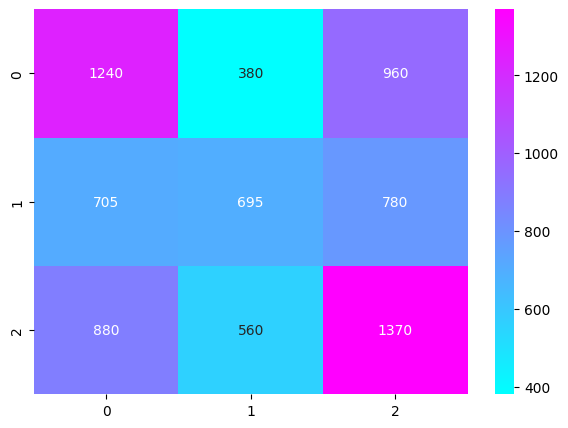

In [89]:
plt.figure(figsize=(7, 5))
sns.heatmap(conm, annot=True, fmt='d', cmap='cool')
plt.show()

### Analysis and Hyperparameter Tuning

Above we can see that our confusion matrix here is all over the place in terms of picking the 3 topics. Although, we can see that topics 0 and 2 did perform slightly better than topic 1. Those topics were lung cancer and colon cancer. Our hyperparameters in this scenario were the ways we vectorized our text and fed it into the LDA. Using both the bag of words approach as well as the TF-IDF approach produced similar results. The primary difference between the two approaches is that compared to regular term frequency BOW, the TF-IDF weighting scheme gives more weight to words which appear in fewer documents and less weight to words which appear in many documents. Next we will look to see whether an LSTM will produce better results.

### LSTM Model Creation

Long short-term memory (LSTM) networks are an extension of an recurrent neural network (RNN) that extend memory. An RNN uses feedback loops which makes it different from other neural networks. Those loops help the RNN to process the sequence of the data. LSTMs were introduced to avoid the long-term dependency problem of RNNs. In a regular RNN, the problem frequently occurs when connecting previous information to new information.

In a bidirectional LSTM, our input flows in two directions, making a bi-lstm different from the regular LSTM. With the regular LSTM, we can make input flow in one direction, either backwards or forward. However, in bi-directional, we can make the input flow in both directions to preserve the future and the past information.

In [90]:
max_words = 5000
max_len = 300

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', df['Text'][0],'\n')
X, tokenizer = tokenize_pad_sequences(df['Text'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 Thyroid surgery in  children in a single institution from Osama Ibrahim Almosallama Ali Aseerib Ahmed Alhumaida Ali S AlZahranic Saif Alsobhib Saud AlShanafeybFrom the  aDepartment of Surgery College of Medicine Qassim University Buraidah Al Qassim Saudi Arabia  bDepartment of Surgery King Faisal Specialist Hospital and Research Center Riyadh Saudi Arabia cDepartment of Medicine King Faisal Specialist Hospital and Research Center Riyadh Saudi Arabia Correspondence   Dr  Osama Ibrahim  Almosallam  Department of  Surgery  College  of  Medicine Qassim  University  PO  Box   Buraidah  Al  Qassim   Saudi  Arabia  osama_iaahotmailcom ORCID orcid0000000290367564        Citation  Almosallam OI Aseeri A Alhumaid A AlZahrani AS Alsobhi S AlShanafey S Thyroid surgery in  children  in  a  single  institution  from   Ann  Saudi  Med         Received January  Accepted May  Published August  Copyright Copyright   Annals of Saudi Medicine Saudi Arabia This is an   acces

After Tokenization & Padding 
 [  77   66  127 2090 1463  207  147    4  225  175   82  187   39    8
   58  569   83  308   15   80    6    6   73   69    6  207  147    4
 1611    3 4943 1667   41   41   69   31  128   69   31   66  127  207
  147  179    4 1611    3 4943   23  165 1145  179    2 2090  207  363
  468  718  147  638   41 2363  445   67 1546 1435 4429   66  127 2090
  207   15   41  958  598  128   69  175   80   69  612   66  127  371
  595    2  207  147    4 1611    3 4943  165    2 1145    2    6  450
 4860    4   41  991  130   77   77  318  764    3  371  595    2    4
 1569  207   15  821   41  958 3118 3732   67  932   34  274 1450    8
 1532  548  363  468  190   38    6 1463  207   15   82  139  713 3446
   23   80 2638 1652 2145 3424 1409 3152   66  127 1569  207  147    4
 1611    3 1370 1202  945    2   17  183   27   76 4860  150  168 3199
  179   31  176    6   69    6   69 1569  147    2    1  207 1878    2
 4793    3 1203 1721    3  273    6 3412   29 

In [91]:
X

array([[  77,   66,  127, ..., 3555,  376, 3368],
       [  38, 2292,  632, ...,  172, 3050,  906],
       [1258,  130, 3316, ...,  659,   54, 3368],
       ...,
       [   2,  863, 4989, ...,   12,  425,  335],
       [   1,   16,    2, ...,    2,    3, 1402],
       [1177,  104,    1, ...,  970,  104,    1]], dtype=int32)

In [93]:
from sklearn.model_selection import train_test_split

In [94]:
y = pd.get_dummies(df.Target)
X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_trn, X_vld, y_trn, y_vld = train_test_split(X_trn, y_trn, test_size=0.3, random_state=42, stratify=y_trn)

print('Train:         ', X_trn.shape, y_trn.shape)
print('Validation Set:', X_vld.shape, y_vld.shape)
print('Test Set:      ', X_tst.shape, y_tst.shape)

Train:          (4239, 300) (4239, 3)
Validation Set: (1817, 300) (1817, 3)
Test Set:       (1514, 300) (1514, 3)


We now have our training, validation and testing set to be able to evaluate if our model is overfitting.

In [97]:
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Sequential, load_model
from keras import losses
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping

In [100]:
vocab_size = 5000
embedding_size = 32
epochs=50

model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='sigmoid'))

In [101]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 300, 32)           160000    
                                                                 
 conv1d_2 (Conv1D)           (None, 300, 32)           3104      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 150, 32)          0         
 1D)                                                             
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                

In [102]:
es = EarlyStopping(monitor = 'val_loss', patience=5)
batch_size = 64

history = model.fit(X_trn, y_trn,
                    validation_data=(X_vld, y_vld),
                    batch_size=batch_size, epochs=epochs, verbose=1,
                    callbacks = [es])

Epoch 1/50


2022-11-12 14:28:57.059924: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-12 14:28:58.303231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-12 14:28:59.009052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-12 14:28:59.034326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-12 14:29:01.875285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-12 14:29:01.892935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - ETA: 0s - loss: 0.9529 - accuracy: 0.4749

2022-11-12 14:29:11.850260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-12 14:29:11.944929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-12 14:29:11.954519: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - 17s 150ms/step - loss: 0.9529 - accuracy: 0.4749 - val_loss: 0.7938 - val_accuracy: 0.7413
Epoch 2/50
67/67 [==============================] - 6s 85ms/step - loss: 0.3950 - accuracy: 0.8417 - val_loss: 0.1410 - val_accuracy: 0.9560
Epoch 3/50
67/67 [==============================] - 6s 84ms/step - loss: 0.0805 - accuracy: 0.9804 - val_loss: 0.0624 - val_accuracy: 0.9840
Epoch 4/50
67/67 [==============================] - 6s 83ms/step - loss: 0.0418 - accuracy: 0.9887 - val_loss: 0.0400 - val_accuracy: 0.9868
Epoch 5/50
67/67 [==============================] - 5s 82ms/step - loss: 0.0341 - accuracy: 0.9908 - val_loss: 0.0287 - val_accuracy: 0.9923
Epoch 6/50
67/67 [==============================] - 5s 82ms/step - loss: 0.0220 - accuracy: 0.9932 - val_loss: 0.0197 - val_accuracy: 0.9906
Epoch 7/50
67/67 [==============================] - 6s 84ms/step - loss: 0.0210 - accuracy: 0.9927 - val_loss: 0.0170 - val_accuracy: 0.9934
Epoch 8/50
67/67 [====

In [103]:
loss, accuracy = model.evaluate(X_tst, y_tst, verbose=0)

# Print metrics
print('Accuracy  : {:.4f}'.format(accuracy))

Accuracy  : 0.9941


Wow, this accuracy is extremely high, let's take a look at our loss vs validation loss graph as well as accuracy vs validation accuracy.

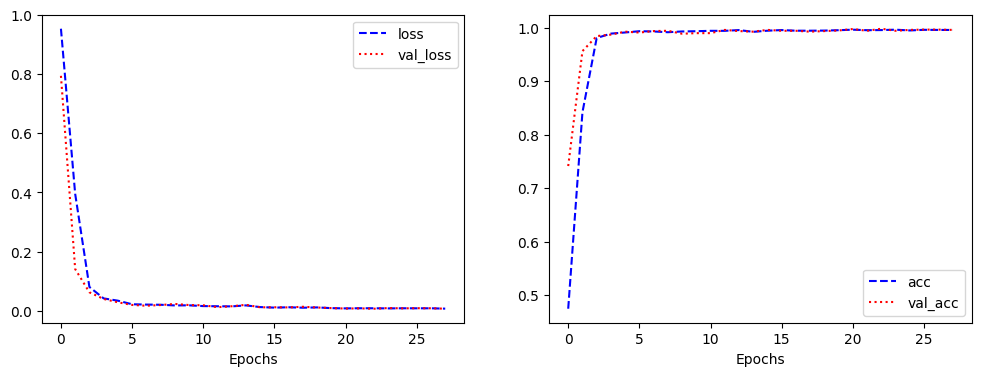

In [104]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b--', label = 'loss')
plt.plot(history.history['val_loss'], 'r:', label = 'val_loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'b--', label = 'acc')
plt.plot(history.history['val_accuracy'], 'r:', label = 'val_acc')
plt.xlabel('Epochs')
plt.legend()

plt.show()

These graphs look very promising. Based on both of them we can see that we leveled off around 5 epochs. There is no major discrepancies between the testing and validation set.

2022-11-12 14:31:46.370931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-12 14:31:46.433875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-12 14:31:46.442839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - 3s 39ms/step


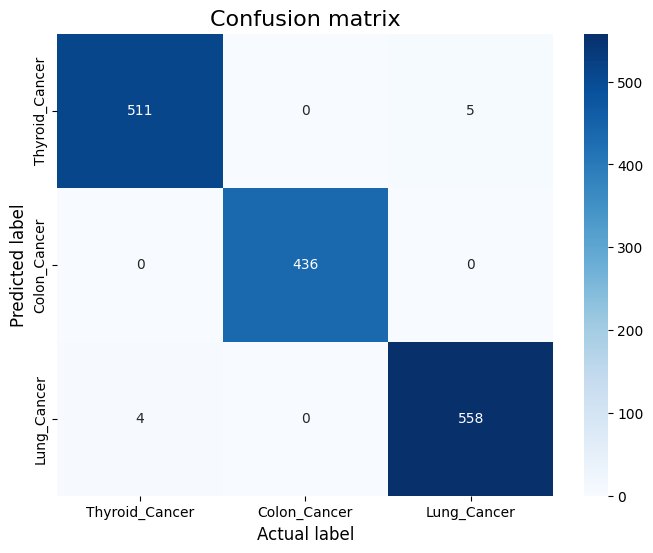

In [105]:
def plot_confusion_matrix(model, X_test, y_test):
    
    classes = ['Thyroid_Cancer', 'Colon_Cancer', 'Lung_Cancer']
    y_pred = model.predict(X_test)
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=classes,
                yticklabels=classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, X_tst, y_tst)

### Analysis and Hyperparameter Discussion

Based on the results we can see our LSTM performed much better than the LDA model. In this case it was very easy to see that supervised learning was the correct choice for our model. The model consisted of 1 convolutional layer, 1 pooling layer, 1 bidirectional layer and 1 dropout layer to help with any overfitting. Lastly we had a dense layer with a sigmoid activation function. Here our hyperparameters to tune are really limitless. There is no cap on the amount of convolutional, pooling or dense layers we can have in our model. Based on the results it can be inferred that a simple LSTM did the trick, thus no further hyperparameter tuning was needed. We can also see that 50 epochs was far too many and that our loss and accuracy really flattened out around 5 epochs.

### Conclusions

The first question we should be asking ourselves is what went wrong in the LDA model and what went right in the LSTM model? LDA is a probabilistic model, which means that it is not always accurate. Additionally, LDA can be slow to converge on a good solution. Lastly, LDA does not work well with short documents, although our text was not incredibly short, 2000-4000 words may have not been enough. For the LSTM, we can attribute the success of the model to many different things, simply put though the architecture for the model allows it to exhibit temporal behavior and capture sequential data which makes it a more 'natural' approach when dealing with textual data since text is naturally sequential.

Sources:

https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

https://medium.com/@aneeshpanoli/classifying-unstructured-healthcare-text-with-natural-language-processing-899bf8a286cf

https://www.tokenex.com/blog/ab-what-is-nlp-natural-language-processing-tokenization/#:~:text=Tokenization%20is%20used%20in%20natural,into%20understandable%20parts%20(words).

https://medium.com/analytics-vidhya/getting-started-with-nlp-tokenization-document-term-matrix-tf-idf-2ea7d01f1942

https://www.tutorialspoint.com/gensim/gensim_creating_a_bag_of_words_corpus.htm

https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/

https://www.kaggle.com/code/mattison/unsupervised-matrix-factorization